In [1]:
%load_ext autoreload
%autoreload 2

### Problem Statement

    Identify products at risk of backorder before the event occurs so that business has time to react.

### What is a Backorder?
    Backorders are products that are temporarily out of stock, but a customer is permitted to place an order against future inventory. A backorder generally indicates that customer demand for a product or service exceeds a company’s capacity to supply it. Back orders are both good and bad. Strong demand can drive back orders, but so can suboptimal planning.

### Data

Data file contains the historical data for the 8 weeks prior to the week we are trying to predict. The data was taken as weekly snapshots at the start of each week. Columns are defined as follows:

    sku - Random ID for the product

    national_inv - Current inventory level for the part

    lead_time - Transit time for product (if available)

    in_transit_qty - Amount of product in transit from source

    forecast_3_month - Forecast sales for the next 3 months

    forecast_6_month - Forecast sales for the next 6 months

    forecast_9_month - Forecast sales for the next 9 months

    sales_1_month - Sales quantity for the prior 1 month time period

    sales_3_month - Sales quantity for the prior 3 month time period

    sales_6_month - Sales quantity for the prior 6 month time period

    sales_9_month - Sales quantity for the prior 9 month time period

    min_bank - Minimum recommend amount to stock

    potential_issue - Source issue for part identified

    pieces_past_due - Parts overdue from source

    perf_6_month_avg - Source performance for prior 6 month period

    perf_12_month_avg - Source performance for prior 12 month period

    local_bo_qty - Amount of stock orders overdue

    deck_risk - Part risk flag

    oe_constraint - Part risk flag

    ppap_risk - Part risk flag

    stop_auto_buy - Part risk flag

    rev_stop - Part risk flag

    went_on_backorder - Product actually went on backorder. This is the target value.

#### Identify Right Error Metrics

    Based on the businees, identify right error metrics.

### Data Pre-processing
#### Loading the required libraries

In [2]:
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_curve, auc

import tensorflow as tf

from keras.regularizers import l2

from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization

from keras.utils import to_categorical
from keras import optimizers
from keras.callbacks import Callback
from keras import backend as K

import matplotlib.pyplot as plt
%matplotlib inline  

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

Using TensorFlow backend.


###### fix random seed for reproducibility

    Generally, Keras gets its source of randomness from the NumPy random number generator.
    
    In addition, TensorFlow has its own random number generator that must also be seeded by calling the set_random_seed() function immediately after the NumPy random number generator, as follows:

In [3]:
np.random.seed(123)

tf.set_random_seed(123)

Get current working directory

In [4]:
PATH = os.getcwd()

Change directory

In [5]:
os.chdir(PATH)

#### Loading the data

In [6]:
data = pd.read_csv("BackOrders.csv",header=0)

#### Understand the Data

See the number row and columns

In [7]:
data.shape

(61589, 23)

Display the columns

In [8]:
data.columns

Index(['sku', 'national_inv', 'lead_time', 'in_transit_qty',
       'forecast_3_month', 'forecast_6_month', 'forecast_9_month',
       'sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month',
       'min_bank', 'potential_issue', 'pieces_past_due', 'perf_6_month_avg',
       'perf_12_month_avg', 'local_bo_qty', 'deck_risk', 'oe_constraint',
       'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder'],
      dtype='object')

Display the index

In [9]:
data.index

RangeIndex(start=0, stop=61589, step=1)

See the top rows of the data

In [10]:
data.head()

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,1888279,117,NaN,0,0,0,0,0,0,15,...,0,-99.00,-99.00,0,No,No,Yes,Yes,No,No
1,1870557,7,2.0,0,0,0,0,0,0,0,...,0,0.50,0.28,0,Yes,No,No,Yes,No,No
2,1475481,258,15.0,10,10,77,184,46,132,256,...,0,0.54,0.70,0,No,No,No,Yes,No,No
3,1758220,46,2.0,0,0,0,0,1,2,6,...,0,0.75,0.90,0,Yes,No,No,Yes,No,No
4,1360312,2,2.0,0,4,6,10,2,2,5,...,0,0.97,0.92,0,No,No,No,Yes,No,No


Shows a quick statistic summary of your data using describe.

    For object data (e.g. strings or timestamps), the result’s index will include count, unique, top, and freq. 

        The top is the most common value.

        The freq is the most common value’s frequency.

In [11]:
data.describe(include='all')

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
count,6.158900e+04,61589.000000,58186.000000,61589.000000,6.158900e+04,6.158900e+04,6.158900e+04,61589.000000,61589.000000,6.158900e+04,...,61589.000000,61589.000000,61589.000000,61589.000000,61589,61589,61589,61589,61589,61589
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2,2,2,2,2,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,No,No,No,Yes,No,No
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,48145,61577,53792,59303,61569,50296
mean,2.037188e+06,287.721882,7.559619,30.192843,1.692728e+02,3.150413e+02,4.535760e+02,44.742957,150.732631,2.835465e+02,...,1.605400,-6.264182,-5.863664,1.205361,NaN,NaN,NaN,NaN,NaN,NaN
std,6.564178e+05,4233.906931,6.498952,792.869253,5.286742e+03,9.774362e+03,1.420201e+04,1373.805831,5224.959649,8.872270e+03,...,42.309229,25.537906,24.844514,29.981155,NaN,NaN,NaN,NaN,NaN,NaN
min,1.068628e+06,-2999.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,...,0.000000,-99.000000,-99.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,1.498574e+06,3.000000,4.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,...,0.000000,0.620000,0.640000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
50%,1.898033e+06,10.000000,8.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,2.000000,4.000000e+00,...,0.000000,0.820000,0.800000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
75%,2.314826e+06,57.000000,8.000000,0.000000,1.200000e+01,2.500000e+01,3.600000e+01,6.000000,17.000000,3.400000e+01,...,0.000000,0.960000,0.950000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN


Display data type of each variable

In [12]:
data.dtypes

sku                    int64
national_inv           int64
lead_time            float64
in_transit_qty         int64
forecast_3_month       int64
forecast_6_month       int64
forecast_9_month       int64
sales_1_month          int64
sales_3_month          int64
sales_6_month          int64
sales_9_month          int64
min_bank               int64
potential_issue       object
pieces_past_due        int64
perf_6_month_avg     float64
perf_12_month_avg    float64
local_bo_qty           int64
deck_risk             object
oe_constraint         object
ppap_risk             object
stop_auto_buy         object
rev_stop              object
went_on_backorder     object
dtype: object

#### Observations

    sku is Categorical but is interpreted as int64 

    potential_issue, deck_risk, oe_constraint, ppap_risk, stop_auto_buy, rev_stop, and went_on_backorder are categorical but is interpreted as object. 

#### Convert all the attributes to appropriate type

Data type conversion

    Using astype('category') to convert potential_issue, deck_risk, oe_constraint, ppap_risk, stop_auto_buy, rev_stop, and went_on_backorder attributes to categorical attributes.


In [13]:
for col in ['sku', 'potential_issue', 'deck_risk', 'oe_constraint', 'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder']:
    data[col] = data[col].astype('category')

Display data type of each variable

In [14]:
data.dtypes

sku                  category
national_inv            int64
lead_time             float64
in_transit_qty          int64
forecast_3_month        int64
forecast_6_month        int64
forecast_9_month        int64
sales_1_month           int64
sales_3_month           int64
sales_6_month           int64
sales_9_month           int64
min_bank                int64
potential_issue      category
pieces_past_due         int64
perf_6_month_avg      float64
perf_12_month_avg     float64
local_bo_qty            int64
deck_risk            category
oe_constraint        category
ppap_risk            category
stop_auto_buy        category
rev_stop             category
went_on_backorder    category
dtype: object

##### Delete sku attribute

In [15]:
np.size(np.unique(data.sku))

61589

In [16]:
data.drop('sku', axis=1, inplace=True)

#### Missing Data

    Missing value analysis and dropping the records with missing values

In [17]:
data.isnull().sum()

national_inv            0
lead_time            3403
in_transit_qty          0
forecast_3_month        0
forecast_6_month        0
forecast_9_month        0
sales_1_month           0
sales_3_month           0
sales_6_month           0
sales_9_month           0
min_bank                0
potential_issue         0
pieces_past_due         0
perf_6_month_avg        0
perf_12_month_avg       0
local_bo_qty            0
deck_risk               0
oe_constraint           0
ppap_risk               0
stop_auto_buy           0
rev_stop                0
went_on_backorder       0
dtype: int64

Observing the number of records before and after missing value records removal

In [18]:
print (data.shape)

(61589, 22)


Since the number of missing values is about 5%. For initial analysis we ignore all these records

In [19]:
data = data.dropna(axis=0)

In [20]:
print(data.isnull().sum())
print("----------------------------------")
print(data.shape)

national_inv         0
lead_time            0
in_transit_qty       0
forecast_3_month     0
forecast_6_month     0
forecast_9_month     0
sales_1_month        0
sales_3_month        0
sales_6_month        0
sales_9_month        0
min_bank             0
potential_issue      0
pieces_past_due      0
perf_6_month_avg     0
perf_12_month_avg    0
local_bo_qty         0
deck_risk            0
oe_constraint        0
ppap_risk            0
stop_auto_buy        0
rev_stop             0
went_on_backorder    0
dtype: int64
----------------------------------
(58186, 22)


#### Converting Categorical to Numeric

For some of the models all the independent attribute should be of type numeric and ANN model is one among them.
But this data set has some categorial attributes.

'pandas.get_dummies' To convert convert categorical variable into dummy/indicator variables


In [21]:
print (data.columns)

Index(['national_inv', 'lead_time', 'in_transit_qty', 'forecast_3_month',
       'forecast_6_month', 'forecast_9_month', 'sales_1_month',
       'sales_3_month', 'sales_6_month', 'sales_9_month', 'min_bank',
       'potential_issue', 'pieces_past_due', 'perf_6_month_avg',
       'perf_12_month_avg', 'local_bo_qty', 'deck_risk', 'oe_constraint',
       'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder'],
      dtype='object')


##### Creating dummy variables.

If we have k levels in a category, then we create k-1 dummy variables as the last one would be redundant. So we use the parameter drop_first in pd.get_dummies function that drops the first level in each of the category


In [22]:
categorical_Attributes = data.select_dtypes(include=['category']).columns

In [23]:
data = pd.get_dummies(columns=categorical_Attributes, 
                      data=data, prefix=categorical_Attributes, 
                      prefix_sep="_",drop_first=True)

In [24]:
print (data.columns, data.shape)

Index(['national_inv', 'lead_time', 'in_transit_qty', 'forecast_3_month',
       'forecast_6_month', 'forecast_9_month', 'sales_1_month',
       'sales_3_month', 'sales_6_month', 'sales_9_month', 'min_bank',
       'pieces_past_due', 'perf_6_month_avg', 'perf_12_month_avg',
       'local_bo_qty', 'potential_issue_Yes', 'deck_risk_Yes',
       'oe_constraint_Yes', 'ppap_risk_Yes', 'stop_auto_buy_Yes',
       'rev_stop_Yes', 'went_on_backorder_Yes'],
      dtype='object') (58186, 22)


#### Train-Test Split

Using sklearn.model_selection.train_test_split

    Split arrays or matrices into train and test subsets

In [25]:
X, y = data.loc[:,data.columns!='went_on_backorder_Yes'].values, data.loc[:,'went_on_backorder_Yes'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123, stratify = data['went_on_backorder_Yes'])

In [26]:
print(X_train.shape)
print(X_test.shape)

(40730, 21)
(17456, 21)


In [27]:
print(pd.value_counts(y_train))
print(pd.value_counts(y_test))

0    33052
1     7678
dtype: int64
0    14165
1     3291
dtype: int64


In [28]:
print(pd.value_counts(y_train)/y_train.size * 100)
print(pd.value_counts(y_test)/y_test.size * 100)

0    81.14903
1    18.85097
dtype: float64
0    81.146884
1    18.853116
dtype: float64


### Standardization of the data

- In data it is not very uncommon to has variables each with different scales. For eg: Age ranges from 0 to 100 and salary may be in thousands. 
    - Scaling by Normalization or min-max scaling
    - Scaling by mean and standard deviation or standardization

1. StandardScaler is a function used to standardize the data .
2. Standardized value for x is computed as (x-mean(column))/standard deviation(column). 

In [29]:
scale = StandardScaler()

In [30]:
scale.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [31]:
X_train_std = scale.transform(X_train)
X_test_std = scale.transform(X_test)

**Anatomy of a neural network**

training a neural network revolves around the following objects:

    - Layers, which are combined into a network (or model)
    - The input data and corresponding targets
    - The loss function, which defines the feedback signal used for learning
      (A loss function — How the network will be able to measure its performance on the training data, and thus how it will be able to steer itself in the right direction.)
    - The optimizer, which determines how learning proceeds
      (The mechanism through which the network will update itself based on the data it sees and its loss function.)

We can visualize their interaction as illustrated in below figure, the network, composed of layers that are chained together, maps the input data to predictions. The loss function then compares these predictions to the targets, producing a loss value: a measure of how well the network’s predictions match what was expected. The optimizer uses this loss value to update the network’s weights.

![Relationship between the network, layers, loss function, and optimizer](nnarchitecture.png)
**<center>Relationship between the network, layers, loss function, and optimizer</center>**

**Layers: the building blocks of deep learning**
    
The fundamental data structure in neural networks is the layer. A layer is a data-processing module that takes as input one or more tensors and that outputs one or more tensors. Some layers are stateless, but more frequently layers have a state: the layer’s weights, one or several tensors learned with stochastic gradient descent, which together contain the network’s knowledge.

We can think of layers as the LEGO bricks of deep learning, a metaphor that is
made explicit by frameworks like Keras. Building deep-learning models in Keras is
done by clipping together compatible layers to form useful data-transformation pipelines.
The notion of layer compatibility here refers specifically to the fact that every layer
will only accept input tensors of a certain shape and will return output tensors of a certain
shape. Consider the following example:

In [148]:
from keras import layers
model = layers.Dense(32, input_shape=(X_train_std.shape[1],))



We’re creating a layer that will only accept as input 2D tensors where the first dimension is 21 (axis 0, the batch dimension, is unspecified, and thus any value would be accepted). This layer will return a tensor where the first dimension has been transformed to be 32.

Thus this layer can only be connected to a downstream layer that expects 32- dimensional vectors as its input. When using Keras, we don’t have to worry about compatibility, because the layers we add to our models are dynamically built to match the shape of the incoming layer.

For instance, suppose we write the following:


In [149]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(32, input_shape=(X_train_std.shape[1],)))
model.add(layers.Dense(1))

In [150]:
model.summary()

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_100 (Dense)            (None, 32)                704       
_________________________________________________________________
dense_101 (Dense)            (None, 1)                 33        
Total params: 737
Trainable params: 737
Non-trainable params: 0
_________________________________________________________________


The second layer didn’t receive an input shape argument — instead, it automatically inferred its input shape as being the output shape of the layer that came before.

**Models: Network of layers**
    
A deep-learning model is a directed, acyclic graph of layers. The most common
instance is a linear stack of layers, mapping a single input to a single output.

**Loss functions and optimizers: keys to configuring the learning process**
    
    Once the network architecture is defined, we still have to choose two more things:

    - Loss function (objective function) — The quantity that will be minimized during training. It represents a measure of success for the task at hand.
    - Optimizer — Determines how the network will be updated based on the loss function. It implements a specific variant of stochastic gradient descent (SGD).

**Introduction to Keras**



Throughout this activity, the code examples use Keras (https://keras.io). Keras is a deep-learning framework for Python that provides a convenient way to define and train almost any kind of deep-learning model. Keras was initially developed for researchers, with the aim of enabling fast experimentation. Keras has the following key features:

    - It allows the same code to run seamlessly on CPU or GPU.
    - It has a user-friendly API that makes it easy to quickly prototype deep-learning models.
    - It has built-in support for convolutional networks (for computer vision), recurrent networks (for sequence processing), and any combination of both.
    - It supports arbitrary network architectures: multi-input or multi-output models, layer sharing, model sharing, and so on. This means Keras is appropriate for building essentially any deep-learning model, from a generative adversarial network to a neural Turing machine.

Keras is distributed under the permissive MIT license, which means it can be freely used in commercial projects. It’s compatible with any version of Python from 2.7 to 3.7

Keras has well over 200,000 users, ranging from academic researchers and engineers at both startups and large companies to graduate students and hobbyists. Keras is used at Google, Netflix, Uber, CERN, Yelp, Square, and hundreds of startups working on a wide range of problems. Keras is also a popular framework on Kaggle, the machine-learning competition website, where almost every recent deep-learning competition has been won using Keras models.

**Keras, TensorFlow, Theano, and CNTK**

Keras is a model-level library, providing high-level building blocks for developing deep-learning models. It doesn’t handle low-level operations such as tensor manipulation and differentiation. Instead, it relies on a specialized, well-optimized tensor library to do so, serving as the backend engine of Keras. Rather than choosing a single tensor library and tying the implementation of Keras to that library, Keras handles the problem in a modular way as shown in the below image; thus several different backend engines can be plugged seamlessly into Keras. Currently, the three existing backend implementations are the TensorFlow backend, the Theano backend, and the Microsoft Cognitive Toolkit (CNTK) backend. In the future, it’s likely that Keras will be extended to work with even more deep-learning execution engines.

TensorFlow, CNTK, and Theano are some of the primary platforms for deep learning today. Theano (http://deeplearning.net/software/theano) is developed by the MILA lab at Université de Montréal, TensorFlow (www.tensorflow.org) is developed by Google, and CNTK (https://github.com/Microsoft/CNTK) is developed by Microsoft. Any piece of code that we write with Keras can be run with any of these backends without having to change anything in the code: we can seamlessly switch between the two during development, which often proves useful—for instance, if one of these backends proves to be faster for a specific task. It is recommended using the TensorFlow backend as the default for most of our deep-learning needs, because it’s the most widely adopted, scalable, and production ready.

Via TensorFlow (or Theano, or CNTK), Keras is able to run seamlessly on both CPUs and GPUs. When running on CPU, TensorFlow is itself wrapping a low-level library for tensor operations called Eigen (http://eigen.tuxfamily.org). On GPU, TensorFlow wraps a library of well-optimized deep-learning operations called the NVIDIA CUDA Deep Neural Network library (cuDNN).

**Developing with Keras: a quick overview**

The typical Keras workflow:

    1. Define our training data: input tensors and target tensors.
    2. Define a network of layers (or model ) that maps our inputs to our targets.
    3. Configure the learning process by choosing a loss function, an optimizer, and some metrics to monitor.
    4. Iterate on our training data by calling the fit() method of our model.

There are two ways to define a model: using the Sequential class (only for linear stacks of layers, which is the most common network architecture by far) or the functional API (for directed acyclic graphs of layers, which lets us build completely arbitrary architectures).

here’s a two-layer model defined using the Sequential class (note that we’re passing the expected shape of the input data to the first layer):


In [151]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(1, activation='sigmoid'))


Once our model architecture is defined,

The learning process is configured in the compilation step, where we specify the optimizer and loss function(s) that the model should use, as well as the metrics we want to monitor during training.

Here’s an example with a single loss function, which is by far the most common case:


In [152]:
from keras import optimizers

model.compile(loss='binary_crossentropy', 
              optimizer='sgd', 
              metrics=['accuracy'])

Finally, the learning process consists of passing Numpy arrays of input data (and the corresponding target data) to the model via the fit() method, similar to what we would do in Scikit-Learn and several other machine-learning libraries:

In [153]:
# model.fit(input_tensor, target_tensor, batch_size=128, epochs=10)

Now we understand what happens when we call fit: the network will start to iterate on the training data in mini-batches of 128 samples, 10 times over (each iteration over all the training data is called an epoch). At each iteration, the network will compute the gradients of the weights with regard to the loss on the batch, and update the weights accordingly. 

### Perceptron Model

In [154]:
np.random.seed(123)

tf.set_random_seed(123)

In [155]:
from keras import models
from keras import layers

perceptron_model = models.Sequential()

perceptron_model.add(layers.Dense(1, 
                           input_shape=(X_train_std.shape[1],), 
                           activation='sigmoid', 
                           kernel_initializer='normal'))

In [156]:
perceptron_model.compile(loss='binary_crossentropy', 
                         optimizer='sgd', 
                         metrics=['accuracy'])

In [157]:
perceptron_model_history = perceptron_model.fit(X_train_std, 
                                                y_train, 
                                                epochs=100, 
                                                batch_size=64, 
                                                validation_split=0.2)

Train on 32584 samples, validate on 8146 samples
Epoch 1/100
32584/32584 [==============================] - 4s 108us/step - loss: 0.5647 - accuracy: 0.7998 - val_loss: 0.5095 - val_accuracy: 0.8053
Epoch 2/100
32584/32584 [==============================] - 2s 59us/step - loss: 0.4855 - accuracy: 0.8137 - val_loss: 0.4889 - val_accuracy: 0.8052
Epoch 3/100
32584/32584 [==============================] - 1s 41us/step - loss: 0.4735 - accuracy: 0.8137 - val_loss: 0.4858 - val_accuracy: 0.8051
Epoch 4/100
32584/32584 [==============================] - 1s 45us/step - loss: 0.4704 - accuracy: 0.8137 - val_loss: 0.4851 - val_accuracy: 0.8049
Epoch 5/100
32584/32584 [==============================] - 2s 59us/step - loss: 0.4692 - accuracy: 0.8137 - val_loss: 0.4850 - val_accuracy: 0.8048
Epoch 6/100
32584/32584 [==============================] - 2s 51us/step - loss: 0.4685 - accuracy: 0.8137 - val_loss: 0.4849 - val_accuracy: 0.8049
Epoch 7/100
32584/32584 [==============================] - 2s 

Epoch 56/100
32584/32584 [==============================] - 2s 52us/step - loss: 0.4630 - accuracy: 0.8143 - val_loss: 0.4807 - val_accuracy: 0.8059
Epoch 57/100
32584/32584 [==============================] - 2s 51us/step - loss: 0.4629 - accuracy: 0.8143 - val_loss: 0.4806 - val_accuracy: 0.8059
Epoch 58/100
32584/32584 [==============================] - 2s 47us/step - loss: 0.4629 - accuracy: 0.8142 - val_loss: 0.4806 - val_accuracy: 0.8059
Epoch 59/100
32584/32584 [==============================] - 2s 46us/step - loss: 0.4628 - accuracy: 0.8142 - val_loss: 0.4805 - val_accuracy: 0.8059
Epoch 60/100
32584/32584 [==============================] - 1s 41us/step - loss: 0.4628 - accuracy: 0.8143 - val_loss: 0.4804 - val_accuracy: 0.8059
Epoch 61/100
32584/32584 [==============================] - 1s 42us/step - loss: 0.4627 - accuracy: 0.8143 - val_loss: 0.4803 - val_accuracy: 0.8059
Epoch 62/100
32584/32584 [==============================] - 1s 44us/step - loss: 0.4627 - accuracy: 0.8143

##### Plot

In [42]:
print(perceptron_model_history.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


In [43]:
from helper import accuracy_plot, loss_plot, compute_metrics

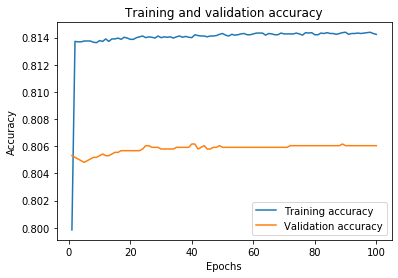

In [44]:
accuracy_plot(perceptron_model_history)

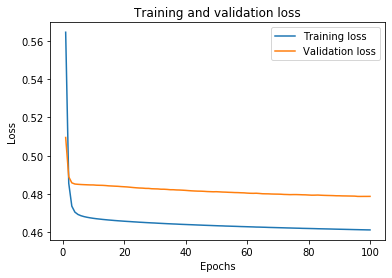

In [45]:
loss_plot(perceptron_model_history)

##### Predictions

In [46]:
train_pred = perceptron_model.predict_classes(X_train_std)
test_pred = perceptron_model.predict_classes(X_test_std)

##### Train Test Accuracy, True Negative Rate and True Positive Rate

In [47]:
compute_metrics(train_pred, y_train, test_pred, y_test)

Train metrics
Confusion matrix
[[33000    52]
 [ 7577   101]]
----------------------------------------------
Accuracy:  0.8126933464276945
Precission:  0.8132686004386721
Recall:  0.9984267215297108
F1 Score:  0.8963859348897852


Test metrics
Confusion matrix
[[14142    23]
 [ 3243    48]]
----------------------------------------------
Accuracy:  0.8129010082493126
Precission:  0.8134598792062122
Recall:  0.9983762795623015
F1 Score:  0.8964817749603803


### MLP with 2 layers

    1 hidden layer with 15 neurons

In [48]:
np.random.seed(123)

tf.set_random_seed(123)

In [49]:
mlp_model1 = models.Sequential()

mlp_model1.add(layers.Dense(64, 
                            input_shape=(X_train_std.shape[1], ), 
                            activation='sigmoid', 
                            kernel_initializer='normal'))

mlp_model1.add(layers.Dense(16, 
                            activation='sigmoid', 
                            kernel_initializer='normal'))

mlp_model1.add(layers.Dense(1, 
                            activation='sigmoid', 
                            kernel_initializer='normal'))

In [50]:
mlp_model1.compile(loss='binary_crossentropy', 
                   optimizer='sgd', 
                   metrics=['accuracy'])

In [51]:
model1_history = mlp_model1.fit(X_train_std, 
                                y_train, 
                                epochs=20, 
                                batch_size=16, 
                                validation_split=0.2)

Train on 32584 samples, validate on 8146 samples
Epoch 1/20
32584/32584 [==============================] - 4s 129us/step - loss: 0.4865 - accuracy: 0.8132 - val_loss: 0.4941 - val_accuracy: 0.8048
Epoch 2/20
32584/32584 [==============================] - 4s 131us/step - loss: 0.4817 - accuracy: 0.8132 - val_loss: 0.4942 - val_accuracy: 0.8048
Epoch 3/20
32584/32584 [==============================] - 4s 124us/step - loss: 0.4817 - accuracy: 0.8132 - val_loss: 0.4937 - val_accuracy: 0.8048
Epoch 4/20
32584/32584 [==============================] - 4s 124us/step - loss: 0.4816 - accuracy: 0.8132 - val_loss: 0.4936 - val_accuracy: 0.8048
Epoch 5/20
32584/32584 [==============================] - 4s 129us/step - loss: 0.4817 - accuracy: 0.8132 - val_loss: 0.4936 - val_accuracy: 0.8048
Epoch 6/20
32584/32584 [==============================] - 4s 128us/step - loss: 0.4816 - accuracy: 0.8132 - val_loss: 0.4935 - val_accuracy: 0.8048
Epoch 7/20
32584/32584 [==============================] - 4s 12

In [52]:
mlp_model1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 64)                1408      
_________________________________________________________________
dense_8 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 17        
Total params: 2,465
Trainable params: 2,465
Non-trainable params: 0
_________________________________________________________________


##### Plot

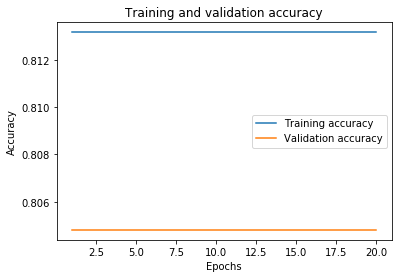

In [53]:
accuracy_plot(model1_history)

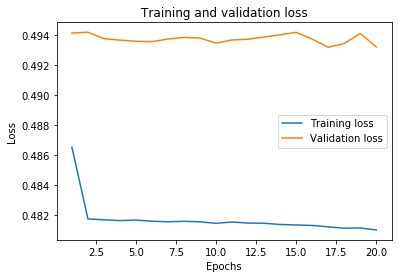

In [54]:
loss_plot(model1_history)

#### Predictions

In [55]:
train_model1_pred = mlp_model1.predict_classes(X_train_std)
test_model1_pred = mlp_model1.predict_classes(X_test_std)

#### Getting evaluation metrics and evaluating model performance

In [56]:
compute_metrics(train_model1_pred, y_train, test_model1_pred, y_test)

Train metrics
Confusion matrix
[[33052     0]
 [ 7678     0]]
----------------------------------------------
Accuracy:  0.8114903019887061
Precission:  0.8114903019887061
Recall:  1.0
F1 Score:  0.8959366783226261


Test metrics
Confusion matrix
[[14165     0]
 [ 3291     0]]
----------------------------------------------
Accuracy:  0.8114688359303391
Precission:  0.8114688359303391
Recall:  1.0
F1 Score:  0.8959235950792195


### MLP with 2 layers

    1 hidden layer with 20 neurons

In [57]:
np.random.seed(123)

tf.set_random_seed(123)

In [58]:
mlp_model2 = models.Sequential()

mlp_model2.add(layers.Dense(20, 
                            input_shape=(X_train_std.shape[1], ), 
                            activation='sigmoid', 
                            kernel_initializer='normal'))

mlp_model2.add(layers.Dense(1, 
                            activation='sigmoid', 
                            kernel_initializer='normal'))

In [59]:
mlp_model2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 20)                440       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 21        
Total params: 461
Trainable params: 461
Non-trainable params: 0
_________________________________________________________________


In [60]:
mlp_model2.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [61]:
model2_history = mlp_model2.fit(X_train_std, y_train, epochs=100, batch_size=64, validation_split=0.2)

Train on 32584 samples, validate on 8146 samples
Epoch 1/100
32584/32584 [==============================] - 1s 40us/step - loss: 0.4972 - accuracy: 0.8132 - val_loss: 0.4940 - val_accuracy: 0.8048
Epoch 2/100
32584/32584 [==============================] - 1s 37us/step - loss: 0.4816 - accuracy: 0.8132 - val_loss: 0.4939 - val_accuracy: 0.8048
Epoch 3/100
32584/32584 [==============================] - 1s 34us/step - loss: 0.4813 - accuracy: 0.8132 - val_loss: 0.4933 - val_accuracy: 0.8048
Epoch 4/100
32584/32584 [==============================] - 1s 33us/step - loss: 0.4810 - accuracy: 0.8132 - val_loss: 0.4933 - val_accuracy: 0.8048
Epoch 5/100
32584/32584 [==============================] - 1s 35us/step - loss: 0.4807 - accuracy: 0.8132 - val_loss: 0.4929 - val_accuracy: 0.8048
Epoch 6/100
32584/32584 [==============================] - 1s 37us/step - loss: 0.4804 - accuracy: 0.8132 - val_loss: 0.4928 - val_accuracy: 0.8048
Epoch 7/100
32584/32584 [==============================] - 1s 3

Epoch 56/100
32584/32584 [==============================] - 1s 35us/step - loss: 0.4685 - accuracy: 0.8135 - val_loss: 0.4831 - val_accuracy: 0.8048
Epoch 57/100
32584/32584 [==============================] - 1s 36us/step - loss: 0.4684 - accuracy: 0.8134 - val_loss: 0.4830 - val_accuracy: 0.8048
Epoch 58/100
32584/32584 [==============================] - 1s 35us/step - loss: 0.4682 - accuracy: 0.8135 - val_loss: 0.4829 - val_accuracy: 0.8048
Epoch 59/100
32584/32584 [==============================] - 1s 33us/step - loss: 0.4681 - accuracy: 0.8135 - val_loss: 0.4827 - val_accuracy: 0.8048
Epoch 60/100
32584/32584 [==============================] - 1s 36us/step - loss: 0.4679 - accuracy: 0.8135 - val_loss: 0.4823 - val_accuracy: 0.8049
Epoch 61/100
32584/32584 [==============================] - 1s 32us/step - loss: 0.4678 - accuracy: 0.8137 - val_loss: 0.4824 - val_accuracy: 0.8049
Epoch 62/100
32584/32584 [==============================] - 1s 34us/step - loss: 0.4676 - accuracy: 0.8137

##### Plot

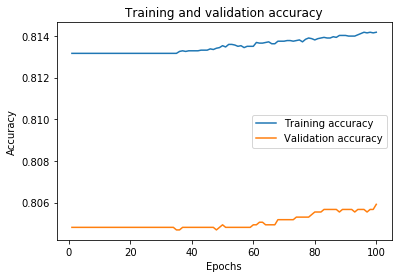

In [62]:
accuracy_plot(model2_history)

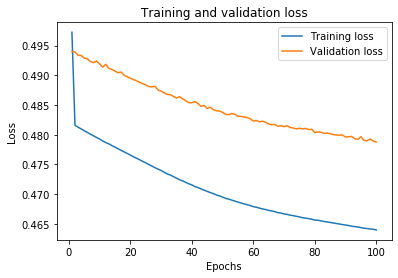

In [63]:
loss_plot(model2_history)

#### Predictions

In [64]:
train_model2_pred = mlp_model2.predict_classes(X_train_std)
test_model2_pred = mlp_model2.predict_classes(X_test_std)

#### Getting evaluation metrics and evaluating model performance

In [65]:
compute_metrics(train_model2_pred, y_train, test_model2_pred, y_test)

Train metrics
Confusion matrix
[[32979    73]
 [ 7560   118]]
----------------------------------------------
Accuracy:  0.8125951387183894
Precission:  0.8135129134907126
Recall:  0.9977913590705555
F1 Score:  0.8962780774823009


Test metrics
Confusion matrix
[[14130    35]
 [ 3239    52]]
----------------------------------------------
Accuracy:  0.812442713107241
Precission:  0.8135183372675456
Recall:  0.9975291210730675
F1 Score:  0.896175556542145


### MLP with 2 layers

    1 hidden layer with 25 neurons

In [66]:
np.random.seed(123)

tf.set_random_seed(123)

In [67]:
mlp_model3 = models.Sequential()

mlp_model3.add(layers.Dense(25, 
                            input_shape=(X_train_std.shape[1], ), 
                            activation='tanh', 
                            kernel_initializer='normal'))

mlp_model3.add(layers.Dense(1, 
                            activation='sigmoid', 
                            kernel_initializer='normal'))

In [68]:
mlp_model3.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 25)                550       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 26        
Total params: 576
Trainable params: 576
Non-trainable params: 0
_________________________________________________________________


In [69]:
mlp_model3.compile(loss='binary_crossentropy', 
                   optimizer='sgd', 
                   metrics=['accuracy'])

In [70]:
model3_history = mlp_model3.fit(X_train_std, 
                                y_train, 
                                epochs=100, 
                                batch_size=64, 
                                validation_split=0.2)

Train on 32584 samples, validate on 8146 samples
Epoch 1/100
32584/32584 [==============================] - 1s 30us/step - loss: 0.5629 - accuracy: 0.8094 - val_loss: 0.5107 - val_accuracy: 0.8048
Epoch 2/100
32584/32584 [==============================] - 1s 25us/step - loss: 0.4888 - accuracy: 0.8132 - val_loss: 0.4926 - val_accuracy: 0.8048
Epoch 3/100
32584/32584 [==============================] - 1s 24us/step - loss: 0.4790 - accuracy: 0.8132 - val_loss: 0.4896 - val_accuracy: 0.8048
Epoch 4/100
32584/32584 [==============================] - 1s 25us/step - loss: 0.4761 - accuracy: 0.8132 - val_loss: 0.4881 - val_accuracy: 0.8048
Epoch 5/100
32584/32584 [==============================] - 1s 24us/step - loss: 0.4742 - accuracy: 0.8132 - val_loss: 0.4867 - val_accuracy: 0.8048
Epoch 6/100
32584/32584 [==============================] - 1s 24us/step - loss: 0.4726 - accuracy: 0.8131 - val_loss: 0.4856 - val_accuracy: 0.8046
Epoch 7/100
32584/32584 [==============================] - 1s 2

Epoch 56/100
32584/32584 [==============================] - 1s 24us/step - loss: 0.4535 - accuracy: 0.8163 - val_loss: 0.4669 - val_accuracy: 0.8097
Epoch 57/100
32584/32584 [==============================] - 1s 24us/step - loss: 0.4532 - accuracy: 0.8164 - val_loss: 0.4668 - val_accuracy: 0.8100
Epoch 58/100
32584/32584 [==============================] - 1s 24us/step - loss: 0.4529 - accuracy: 0.8166 - val_loss: 0.4664 - val_accuracy: 0.8102
Epoch 59/100
32584/32584 [==============================] - 1s 24us/step - loss: 0.4526 - accuracy: 0.8164 - val_loss: 0.4661 - val_accuracy: 0.8100
Epoch 60/100
32584/32584 [==============================] - 1s 24us/step - loss: 0.4523 - accuracy: 0.8166 - val_loss: 0.4656 - val_accuracy: 0.8103
Epoch 61/100
32584/32584 [==============================] - 1s 24us/step - loss: 0.4521 - accuracy: 0.8165 - val_loss: 0.4653 - val_accuracy: 0.8107
Epoch 62/100
32584/32584 [==============================] - 1s 25us/step - loss: 0.4518 - accuracy: 0.8166

##### Plot

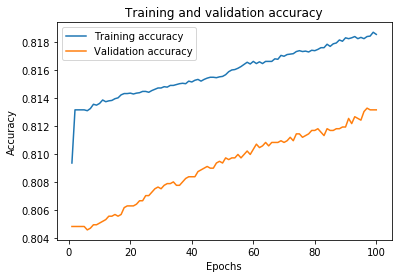

In [71]:
accuracy_plot(model3_history)

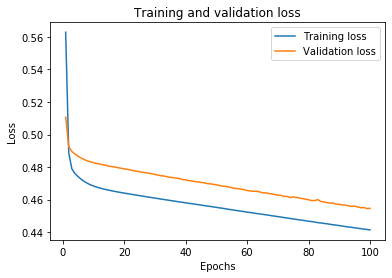

In [72]:
loss_plot(model3_history)

#### Predictions

In [73]:
train_model3_pred = mlp_model3.predict_classes(X_train_std)
test_model3_pred = mlp_model3.predict_classes(X_test_std)

#### Getting evaluation metrics and evaluating model performance

In [74]:
compute_metrics(train_model3_pred, y_train, test_model3_pred, y_test)

Train metrics
Confusion matrix
[[32883   169]
 [ 7251   427]]
----------------------------------------------
Accuracy:  0.8178246992388902
Precission:  0.8193302436836597
Recall:  0.99488684497156
F1 Score:  0.8986144891099389


Test metrics
Confusion matrix
[[14087    78]
 [ 3094   197]]
----------------------------------------------
Accuracy:  0.8182859761686526
Precission:  0.8199173505616669
Recall:  0.9944934698199788
F1 Score:  0.8988068653097683


### MLP with 3 layers

    1st hidden layer with 25 neurons
    2nd hidden layer with 15 neurons

In [75]:
np.random.seed(123)

tf.set_random_seed(123)

In [76]:
mlp_model4 = models.Sequential()

mlp_model4.add(layers.Dense(25, 
                            input_shape=(X_train_std.shape[1], ), 
                            activation='tanh', 
                            kernel_initializer='normal'))

mlp_model4.add(layers.Dense(15, 
                            activation='tanh', 
                            kernel_initializer='normal'))

mlp_model4.add(layers.Dense(1, 
                            activation='sigmoid', 
                            kernel_initializer='normal'))

In [77]:
mlp_model4.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 25)                550       
_________________________________________________________________
dense_15 (Dense)             (None, 15)                390       
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 16        
Total params: 956
Trainable params: 956
Non-trainable params: 0
_________________________________________________________________


In [78]:
mlp_model4.compile(loss='binary_crossentropy', 
                   optimizer='sgd', 
                   metrics=['accuracy'])

In [79]:
model4_history = mlp_model4.fit(X_train_std, 
                                y_train, 
                                epochs=100, 
                                batch_size=64, 
                                validation_split=0.2)

Train on 32584 samples, validate on 8146 samples
Epoch 1/100
32584/32584 [==============================] - 1s 31us/step - loss: 0.5635 - accuracy: 0.8119 - val_loss: 0.5116 - val_accuracy: 0.8048
Epoch 2/100
32584/32584 [==============================] - 1s 25us/step - loss: 0.4906 - accuracy: 0.8132 - val_loss: 0.4948 - val_accuracy: 0.8048
Epoch 3/100
32584/32584 [==============================] - 1s 25us/step - loss: 0.4823 - accuracy: 0.8132 - val_loss: 0.4931 - val_accuracy: 0.8048
Epoch 4/100
32584/32584 [==============================] - 1s 25us/step - loss: 0.4809 - accuracy: 0.8132 - val_loss: 0.4928 - val_accuracy: 0.8048
Epoch 5/100
32584/32584 [==============================] - 1s 25us/step - loss: 0.4804 - accuracy: 0.8132 - val_loss: 0.4925 - val_accuracy: 0.8048
Epoch 6/100
32584/32584 [==============================] - 1s 24us/step - loss: 0.4799 - accuracy: 0.8132 - val_loss: 0.4921 - val_accuracy: 0.8048
Epoch 7/100
32584/32584 [==============================] - 1s 2

Epoch 56/100
32584/32584 [==============================] - 1s 26us/step - loss: 0.4496 - accuracy: 0.8171 - val_loss: 0.4627 - val_accuracy: 0.8111
Epoch 57/100
32584/32584 [==============================] - 1s 27us/step - loss: 0.4491 - accuracy: 0.8174 - val_loss: 0.4621 - val_accuracy: 0.8110
Epoch 58/100
32584/32584 [==============================] - 1s 26us/step - loss: 0.4485 - accuracy: 0.8173 - val_loss: 0.4610 - val_accuracy: 0.8114
Epoch 59/100
32584/32584 [==============================] - 1s 26us/step - loss: 0.4481 - accuracy: 0.8175 - val_loss: 0.4607 - val_accuracy: 0.8118
Epoch 60/100
32584/32584 [==============================] - 1s 27us/step - loss: 0.4475 - accuracy: 0.8177 - val_loss: 0.4607 - val_accuracy: 0.8116
Epoch 61/100
32584/32584 [==============================] - 1s 26us/step - loss: 0.4471 - accuracy: 0.8176 - val_loss: 0.4596 - val_accuracy: 0.8124
Epoch 62/100
32584/32584 [==============================] - 1s 27us/step - loss: 0.4464 - accuracy: 0.8175

##### Plot

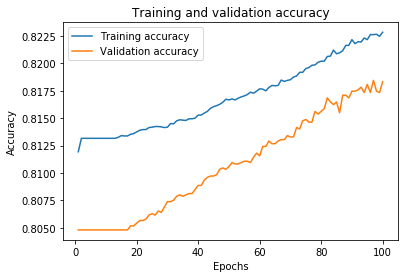

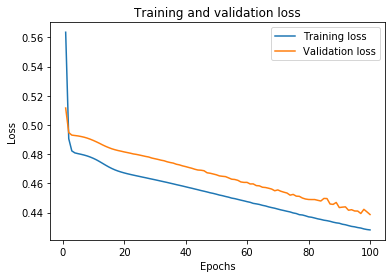

In [80]:
accuracy_plot(model4_history)
loss_plot(model4_history)

#### Predictions

In [81]:
train_model4_pred = mlp_model4.predict_classes(X_train_std)
test_model4_pred = mlp_model4.predict_classes(X_test_std)

#### Getting evaluation metrics and evaluating model performance

In [82]:
compute_metrics(train_model4_pred, y_train, test_model4_pred, y_test)

Train metrics
Confusion matrix
[[32802   250]
 [ 6990   688]]
----------------------------------------------
Accuracy:  0.8222440461576234
Precission:  0.8243365500603136
Recall:  0.9924361612005325
F1 Score:  0.9006095217176432


Test metrics
Confusion matrix
[[14049   116]
 [ 2990   301]]
----------------------------------------------
Accuracy:  0.8220669110907425
Precission:  0.8245202183226715
Recall:  0.9918108012707377
F1 Score:  0.9004614792975261


### MLP with 3 layers

    1st hidden layer with 25 neurons
    2nd hidden layer with 20 neurons

In [83]:
np.random.seed(123)

tf.set_random_seed(123)

In [84]:
mlp_model5 = models.Sequential()

mlp_model5.add(layers.Dense(25, 
                            input_shape=(X_train_std.shape[1], ), 
                            activation='tanh', 
                            kernel_initializer='normal'))

mlp_model5.add(layers.Dense(20, 
                            activation='tanh', 
                            kernel_initializer='normal'))

mlp_model5.add(layers.Dense(1, 
                            activation='sigmoid', 
                            kernel_initializer='normal'))

In [85]:
mlp_model5.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 25)                550       
_________________________________________________________________
dense_18 (Dense)             (None, 20)                520       
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 21        
Total params: 1,091
Trainable params: 1,091
Non-trainable params: 0
_________________________________________________________________


In [86]:
mlp_model5.compile(loss='binary_crossentropy', 
                   optimizer='sgd', 
                   metrics=['accuracy'])

In [87]:
model5_history = mlp_model5.fit(X_train_std, 
                                y_train, 
                                epochs=100, 
                                batch_size=64, 
                                validation_split=0.2)

Train on 32584 samples, validate on 8146 samples
Epoch 1/100
32584/32584 [==============================] - 1s 33us/step - loss: 0.5614 - accuracy: 0.8120 - val_loss: 0.5096 - val_accuracy: 0.8048
Epoch 2/100
32584/32584 [==============================] - 1s 26us/step - loss: 0.4891 - accuracy: 0.8132 - val_loss: 0.4940 - val_accuracy: 0.8048
Epoch 3/100
32584/32584 [==============================] - 1s 26us/step - loss: 0.4816 - accuracy: 0.8132 - val_loss: 0.4927 - val_accuracy: 0.8048
Epoch 4/100
32584/32584 [==============================] - 1s 25us/step - loss: 0.4805 - accuracy: 0.8132 - val_loss: 0.4924 - val_accuracy: 0.8048
Epoch 5/100
32584/32584 [==============================] - 1s 26us/step - loss: 0.4799 - accuracy: 0.8132 - val_loss: 0.4920 - val_accuracy: 0.8048
Epoch 6/100
32584/32584 [==============================] - 1s 26us/step - loss: 0.4794 - accuracy: 0.8132 - val_loss: 0.4915 - val_accuracy: 0.8048
Epoch 7/100
32584/32584 [==============================] - 1s 2

Epoch 56/100
32584/32584 [==============================] - 1s 26us/step - loss: 0.4489 - accuracy: 0.8172 - val_loss: 0.4621 - val_accuracy: 0.8110
Epoch 57/100
32584/32584 [==============================] - 1s 25us/step - loss: 0.4483 - accuracy: 0.8174 - val_loss: 0.4615 - val_accuracy: 0.8112
Epoch 58/100
32584/32584 [==============================] - 1s 26us/step - loss: 0.4478 - accuracy: 0.8174 - val_loss: 0.4603 - val_accuracy: 0.8117
Epoch 59/100
32584/32584 [==============================] - 1s 26us/step - loss: 0.4473 - accuracy: 0.8175 - val_loss: 0.4599 - val_accuracy: 0.8121
Epoch 60/100
32584/32584 [==============================] - 1s 28us/step - loss: 0.4467 - accuracy: 0.8178 - val_loss: 0.4599 - val_accuracy: 0.8117
Epoch 61/100
32584/32584 [==============================] - 1s 27us/step - loss: 0.4462 - accuracy: 0.8178 - val_loss: 0.4588 - val_accuracy: 0.8123
Epoch 62/100
32584/32584 [==============================] - 1s 29us/step - loss: 0.4454 - accuracy: 0.8177

##### Plot

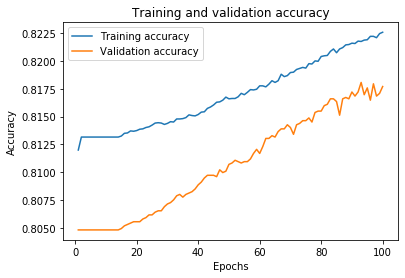

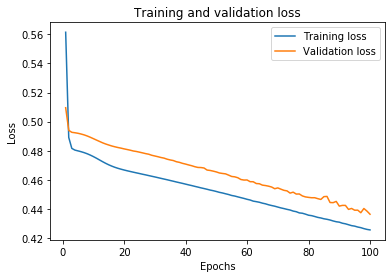

In [88]:
accuracy_plot(model5_history)
loss_plot(model5_history)

#### Predictions

In [89]:
train_model5_pred = mlp_model5.predict_classes(X_train_std)
test_model5_pred = mlp_model5.predict_classes(X_test_std)

#### Getting evaluation metrics and evaluating model performance

In [90]:
compute_metrics(train_model5_pred, y_train, test_model5_pred, y_test)

Train metrics
Confusion matrix
[[32797   255]
 [ 7000   678]]
----------------------------------------------
Accuracy:  0.8218757672477289
Precission:  0.8241073447747318
Recall:  0.9922848844245431
F1 Score:  0.9004104380293484


Test metrics
Confusion matrix
[[14050   115]
 [ 2994   297]]
----------------------------------------------
Accuracy:  0.8218950504124656
Precission:  0.8243370100915278
Recall:  0.9918813978115072
F1 Score:  0.900381300265949


### MLP with 4 layers

    1st hidden layer with 25 neurons
    2nd hidden layer with 20 neurons
    3nd hidden layer with 15 neurons

In [91]:
np.random.seed(123)

tf.set_random_seed(123)

In [92]:
mlp_model6 = models.Sequential()

mlp_model6.add(layers.Dense(25, 
                     input_shape=(X_train_std.shape[1], ), 
                     activation='tanh', 
                     kernel_initializer='normal'))

mlp_model6.add(layers.Dense(20, 
                     activation='tanh', 
                     kernel_initializer='normal'))

mlp_model6.add(layers.Dense(15, 
                     activation='tanh', 
                     kernel_initializer='normal'))

mlp_model6.add(layers.Dense(1, 
                     activation='sigmoid', 
                     kernel_initializer='normal'))

In [93]:
mlp_model6.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 25)                550       
_________________________________________________________________
dense_21 (Dense)             (None, 20)                520       
_________________________________________________________________
dense_22 (Dense)             (None, 15)                315       
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 16        
Total params: 1,401
Trainable params: 1,401
Non-trainable params: 0
_________________________________________________________________


In [94]:
mlp_model6.compile(loss='binary_crossentropy', 
                   optimizer='sgd', 
                   metrics=['accuracy'])

In [95]:
model6_history = mlp_model6.fit(X_train_std, 
                                y_train, 
                                epochs=100, 
                                batch_size=64, 
                                validation_split=0.2)

Train on 32584 samples, validate on 8146 samples
Epoch 1/100
32584/32584 [==============================] - 1s 38us/step - loss: 0.5629 - accuracy: 0.8126 - val_loss: 0.5111 - val_accuracy: 0.8048
Epoch 2/100
32584/32584 [==============================] - 1s 28us/step - loss: 0.4906 - accuracy: 0.8132 - val_loss: 0.4951 - val_accuracy: 0.8048
Epoch 3/100
32584/32584 [==============================] - 1s 27us/step - loss: 0.4828 - accuracy: 0.8132 - val_loss: 0.4937 - val_accuracy: 0.8048
Epoch 4/100
32584/32584 [==============================] - 1s 26us/step - loss: 0.4818 - accuracy: 0.8132 - val_loss: 0.4938 - val_accuracy: 0.8048
Epoch 5/100
32584/32584 [==============================] - 1s 27us/step - loss: 0.4817 - accuracy: 0.8132 - val_loss: 0.4939 - val_accuracy: 0.8048
Epoch 6/100
32584/32584 [==============================] - 1s 28us/step - loss: 0.4816 - accuracy: 0.8132 - val_loss: 0.4939 - val_accuracy: 0.8048
Epoch 7/100
32584/32584 [==============================] - 1s 2

Epoch 56/100
32584/32584 [==============================] - 1s 28us/step - loss: 0.4642 - accuracy: 0.8141 - val_loss: 0.4786 - val_accuracy: 0.8062
Epoch 57/100
32584/32584 [==============================] - 1s 29us/step - loss: 0.4635 - accuracy: 0.8142 - val_loss: 0.4779 - val_accuracy: 0.8062
Epoch 58/100
32584/32584 [==============================] - 1s 28us/step - loss: 0.4629 - accuracy: 0.8141 - val_loss: 0.4773 - val_accuracy: 0.8067
Epoch 59/100
32584/32584 [==============================] - 1s 27us/step - loss: 0.4622 - accuracy: 0.8142 - val_loss: 0.4766 - val_accuracy: 0.8068
Epoch 60/100
32584/32584 [==============================] - 1s 28us/step - loss: 0.4616 - accuracy: 0.8142 - val_loss: 0.4759 - val_accuracy: 0.8071
Epoch 61/100
32584/32584 [==============================] - 1s 27us/step - loss: 0.4608 - accuracy: 0.8143 - val_loss: 0.4752 - val_accuracy: 0.8076
Epoch 62/100
32584/32584 [==============================] - 1s 27us/step - loss: 0.4600 - accuracy: 0.8146

#### Predictions

In [96]:
train_model6_pred = mlp_model6.predict_classes(X_train_std)
test_model6_pred = mlp_model6.predict_classes(X_test_std)

#### Getting evaluation metrics and evaluating model performance

In [97]:
compute_metrics(train_model6_pred, y_train, test_model6_pred, y_test)

Train metrics
Confusion matrix
[[32728   324]
 [ 6943   735]]
----------------------------------------------
Accuracy:  0.8215811441198134
Precission:  0.8249855057850823
Recall:  0.9901972649158901
F1 Score:  0.9000728792816578


Test metrics
Confusion matrix
[[14022   143]
 [ 2971   320]]
----------------------------------------------
Accuracy:  0.821608615948671
Precission:  0.8251633025363385
Recall:  0.9899046946699612
F1 Score:  0.9000577700751011


## Find best parameter

#### Function for creation of model

In [98]:
def model_def(h_activation, o_activation, kernel_init):
    
    model= models.Sequential()
    
    model.add(layers.Dense(25, 
                           input_shape=(X_train_std.shape[1], ),  
                           activation=h_activation, 
                           kernel_initializer=kernel_init))
    
    model.add(layers.Dense(15, 
                           activation=h_activation, 
                           kernel_initializer=kernel_init))
    
    model.add(layers.Dense(1, 
                           activation=o_activation, 
                           kernel_initializer=kernel_init))
    
    return model 

#### Store the best parameters

In [99]:
best_params={}

### Find the best Learning rate

    Using logarithmic scale randomly generate values between 0.0001 to 1 

In [100]:
NUM_LR = 10 

lrs = [round(i, 4) for i in list(10 ** (-4 * np.random.rand(NUM_LR)))]

lrs

[0.2703, 0.0144, 0.0214, 0.0003, 0.0002, 0.0008, 0.1425, 0.0049, 0.022, 0.1388]

In [101]:
hist_loss = []

for lr in lrs:
    
    np.random.seed(123)
    tf.set_random_seed(123)
    
    lr_model = model_def(h_activation='tanh', 
                         o_activation='sigmoid', 
                         kernel_init='normal')
    
    # Compile model
    sgd = optimizers.SGD(lr=lr)
    
    lr_model.compile(loss='binary_crossentropy', 
                     optimizer=sgd, 
                     metrics=['accuracy'])
    
    # Fit the model
    lr_model_history = lr_model.fit(X_train_std, 
                                    y_train, 
                                    validation_split=0.2, 
                                    epochs=1, 
                                    steps_per_epoch=50, 
                                    validation_steps=50)
    
    hist_loss.append(lr_model_history.history['loss'])

Train on 32584 samples, validate on 8146 samples
Epoch 1/1
50/50 [==============================] - 1s 24ms/step - loss: 0.5173 - accuracy: 0.8026 - val_loss: 0.0099 - val_accuracy: 40.2406
Train on 32584 samples, validate on 8146 samples
Epoch 1/1
50/50 [==============================] - 1s 23ms/step - loss: 0.6613 - accuracy: 0.7991 - val_loss: 0.0127 - val_accuracy: 40.2406
Train on 32584 samples, validate on 8146 samples
Epoch 1/1
50/50 [==============================] - 1s 24ms/step - loss: 0.6483 - accuracy: 0.8003 - val_loss: 0.0122 - val_accuracy: 40.2406
Train on 32584 samples, validate on 8146 samples
Epoch 1/1
50/50 [==============================] - 1s 26ms/step - loss: 0.6925 - accuracy: 0.5854 - val_loss: 0.0138 - val_accuracy: 34.7103
Train on 32584 samples, validate on 8146 samples
Epoch 1/1
50/50 [==============================] - 1s 23ms/step - loss: 0.6927 - accuracy: 0.5324 - val_loss: 0.0138 - val_accuracy: 34.4341
Train on 32584 samples, validate on 8146 samples
E

In [102]:
# Get the lr and loss Dataframe
loss_lr = pd.DataFrame([lrs,hist_loss]).T  

#Give the coloumn names
loss_lr.columns=['lr', 'loss']

#Sort the values and reset the index
loss_lr=loss_lr.sort_values('loss').reset_index().drop('index',axis=1)
loss_lr

,lr,loss
0,0.2703,[0.5172672504186631]
1,0.1425,[0.5455174481868744]
2,0.1388,[0.5469303399324417]
3,0.022,[0.6472453677654266]
4,0.0214,[0.6482957184314728]
5,0.0144,[0.6613145887851715]
6,0.0049,[0.6815103983879089]
7,0.0008,[0.6912540888786316]
8,0.0003,[0.6924888026714325]
9,0.0002,[0.6927370011806488]


In [103]:
#pick the top lr
best_params['best_learning_rate'] = loss_lr.loc[:,'lr'][0]

#### Build model with the best learning rate

In [104]:
np.random.seed(123)
tf.set_random_seed(123)

In [105]:
bst_lr_model = model_def(h_activation='tanh', 
                         o_activation='sigmoid', 
                         kernel_init='normal')

In [106]:
bst_lr_model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_54 (Dense)             (None, 25)                550       
_________________________________________________________________
dense_55 (Dense)             (None, 15)                390       
_________________________________________________________________
dense_56 (Dense)             (None, 1)                 16        
Total params: 956
Trainable params: 956
Non-trainable params: 0
_________________________________________________________________


In [107]:
sgd = optimizers.SGD(lr=best_params['best_learning_rate'])

bst_lr_model.compile(loss='binary_crossentropy', 
                     optimizer=sgd, 
                     metrics=['accuracy'])

In [108]:
bst_lr_model_history = bst_lr_model.fit(X_train_std, 
                                        y_train, 
                                        epochs=100, 
                                        batch_size=64, 
                                        validation_split=0.2, 
                                        shuffle=True)

Train on 32584 samples, validate on 8146 samples
Epoch 1/100
32584/32584 [==============================] - 2s 59us/step - loss: 0.4770 - accuracy: 0.8122 - val_loss: 0.4798 - val_accuracy: 0.8064
Epoch 2/100
32584/32584 [==============================] - 1s 42us/step - loss: 0.4613 - accuracy: 0.8149 - val_loss: 0.4760 - val_accuracy: 0.8100
Epoch 3/100
32584/32584 [==============================] - 1s 41us/step - loss: 0.4545 - accuracy: 0.8164 - val_loss: 0.4705 - val_accuracy: 0.8110
Epoch 4/100
32584/32584 [==============================] - 1s 40us/step - loss: 0.4487 - accuracy: 0.8175 - val_loss: 0.4690 - val_accuracy: 0.8046
Epoch 5/100
32584/32584 [==============================] - 1s 41us/step - loss: 0.4430 - accuracy: 0.8183 - val_loss: 0.5288 - val_accuracy: 0.7755
Epoch 6/100
32584/32584 [==============================] - 1s 42us/step - loss: 0.4378 - accuracy: 0.8193 - val_loss: 0.4463 - val_accuracy: 0.8178
Epoch 7/100
32584/32584 [==============================] - 1s 4

Epoch 56/100
32584/32584 [==============================] - 1s 38us/step - loss: 0.3844 - accuracy: 0.8352 - val_loss: 0.3871 - val_accuracy: 0.8297
Epoch 57/100
32584/32584 [==============================] - 1s 39us/step - loss: 0.3851 - accuracy: 0.8331 - val_loss: 0.4538 - val_accuracy: 0.8243
Epoch 58/100
32584/32584 [==============================] - 1s 37us/step - loss: 0.3824 - accuracy: 0.8336 - val_loss: 0.5493 - val_accuracy: 0.6406
Epoch 59/100
32584/32584 [==============================] - 1s 38us/step - loss: 0.3835 - accuracy: 0.8341 - val_loss: 0.3915 - val_accuracy: 0.8339
Epoch 60/100
32584/32584 [==============================] - 1s 37us/step - loss: 0.3819 - accuracy: 0.8343 - val_loss: 0.4622 - val_accuracy: 0.8270
Epoch 61/100
32584/32584 [==============================] - 1s 39us/step - loss: 0.3830 - accuracy: 0.8346 - val_loss: 0.4840 - val_accuracy: 0.8260
Epoch 62/100
32584/32584 [==============================] - 1s 39us/step - loss: 0.3798 - accuracy: 0.8350

#### Predictions

In [109]:
train_bst_lr_model_pred = bst_lr_model.predict_classes(X_train_std)
test_bst_lr_model_pred = bst_lr_model.predict_classes(X_test_std)

#### Getting evaluation metrics and evaluating model performance

In [110]:
compute_metrics(train_bst_lr_model_pred, y_train, test_bst_lr_model_pred, y_test)

Train metrics
Confusion matrix
[[32542   510]
 [ 6205  1473]]
----------------------------------------------
Accuracy:  0.8351338080039283
Precission:  0.8398585696957184
Recall:  0.9845697688490863
F1 Score:  0.9064750205434615


Test metrics
Confusion matrix
[[13926   239]
 [ 2652   639]]
----------------------------------------------
Accuracy:  0.8343835930339139
Precission:  0.8400289540354687
Recall:  0.983127426756089
F1 Score:  0.9059623328887877


#### Find the best Batch size 

In [111]:
batch_sizes = [32, 64, 128, 256]

In [112]:
history=[]

for batch_size in batch_sizes:
    
    np.random.seed(123)
    tf.set_random_seed(123)
    
    bs_model = model_def(h_activation='tanh', 
                         o_activation='sigmoid', 
                         kernel_init='normal')
    
     # Compile model
    sgd = optimizers.SGD(lr=best_params['best_learning_rate'])
    
    bs_model.compile(loss='binary_crossentropy', 
                     optimizer=sgd, 
                     metrics=['accuracy'])
    
    #Fit the model
    bs_model_history = bs_model.fit(X_train_std, 
                                    y_train, 
                                    batch_size=batch_size, 
                                    epochs=10,
                                    validation_split=0.2, shuffle=True)
    
    history.append(bs_model_history)

Train on 32584 samples, validate on 8146 samples
Epoch 1/10
32584/32584 [==============================] - 3s 98us/step - loss: 0.4707 - accuracy: 0.8135 - val_loss: 0.4746 - val_accuracy: 0.8091
Epoch 2/10
32584/32584 [==============================] - 3s 88us/step - loss: 0.4559 - accuracy: 0.8165 - val_loss: 0.4668 - val_accuracy: 0.8124
Epoch 3/10
32584/32584 [==============================] - 3s 86us/step - loss: 0.4478 - accuracy: 0.8171 - val_loss: 0.4573 - val_accuracy: 0.8129
Epoch 4/10
32584/32584 [==============================] - 2s 73us/step - loss: 0.4414 - accuracy: 0.8183 - val_loss: 0.4487 - val_accuracy: 0.8086
Epoch 5/10
32584/32584 [==============================] - 4s 126us/step - loss: 0.4358 - accuracy: 0.8196 - val_loss: 0.4806 - val_accuracy: 0.8048
Epoch 6/10
32584/32584 [==============================] - 4s 118us/step - loss: 0.4301 - accuracy: 0.8208 - val_loss: 0.4305 - val_accuracy: 0.8187
Epoch 7/10
32584/32584 [==============================] - 3s 90us/s

###### Summarize history for train loss

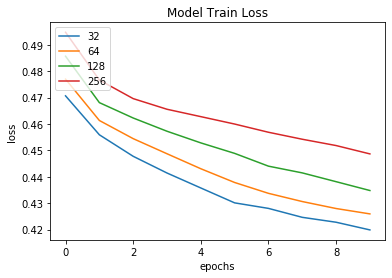

In [113]:
for i in range(0, len(history)):
    plt.plot(history[i].history['loss'])
plt.title('Model Train Loss')
plt.ylabel('loss')
plt.xlabel('epochs')  
plt.legend(batch_sizes, loc='upper left')
plt.show()

###### Summarize history for test loss

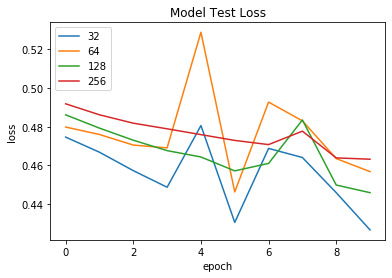

In [114]:
for i in range(0, len(history)):
    plt.plot(history[i].history['val_loss'])
plt.title('Model Test Loss')
plt.ylabel('loss')
plt.xlabel('epoch')  
plt.legend(batch_sizes, loc='upper left')
plt.show()

#### Build model with the best batch size

In [115]:
best_params['best_batch_size'] = 32

In [116]:
np.random.seed(123)
tf.set_random_seed(123)
    
bst_bs_model = model_def(h_activation='tanh', 
                         o_activation='sigmoid', 
                         kernel_init='normal')

In [117]:
sgd = optimizers.SGD(lr=best_params['best_learning_rate'])

bst_bs_model.compile(loss='binary_crossentropy', 
                     optimizer=sgd, 
                     metrics=['accuracy'])

In [118]:
bst_bs_model_history = bst_bs_model.fit(X_train_std, 
                                        y_train, 
                                        epochs=100, 
                                        batch_size=best_params['best_batch_size'],
                                        validation_split=0.2, 
                                        shuffle=True)

Train on 32584 samples, validate on 8146 samples
Epoch 1/100
32584/32584 [==============================] - 3s 103us/step - loss: 0.4707 - accuracy: 0.8135 - val_loss: 0.4746 - val_accuracy: 0.8091
Epoch 2/100
32584/32584 [==============================] - 2s 75us/step - loss: 0.4559 - accuracy: 0.8165 - val_loss: 0.4668 - val_accuracy: 0.8124
Epoch 3/100
32584/32584 [==============================] - 2s 75us/step - loss: 0.4478 - accuracy: 0.8171 - val_loss: 0.4573 - val_accuracy: 0.8129
Epoch 4/100
32584/32584 [==============================] - 3s 89us/step - loss: 0.4414 - accuracy: 0.8183 - val_loss: 0.4487 - val_accuracy: 0.8086
Epoch 5/100
32584/32584 [==============================] - 2s 73us/step - loss: 0.4358 - accuracy: 0.8196 - val_loss: 0.4806 - val_accuracy: 0.8048
Epoch 6/100
32584/32584 [==============================] - 2s 67us/step - loss: 0.4301 - accuracy: 0.8208 - val_loss: 0.4305 - val_accuracy: 0.8187
Epoch 7/100
32584/32584 [==============================] - 3s 

Epoch 56/100
32584/32584 [==============================] - 2s 63us/step - loss: 0.3788 - accuracy: 0.8352 - val_loss: 0.3734 - val_accuracy: 0.8339
Epoch 57/100
32584/32584 [==============================] - 2s 64us/step - loss: 0.3757 - accuracy: 0.8373 - val_loss: 0.4030 - val_accuracy: 0.8300
Epoch 58/100
32584/32584 [==============================] - 2s 64us/step - loss: 0.3782 - accuracy: 0.8358 - val_loss: 0.4605 - val_accuracy: 0.7965
Epoch 59/100
32584/32584 [==============================] - 2s 69us/step - loss: 0.3759 - accuracy: 0.8346 - val_loss: 0.3758 - val_accuracy: 0.8367
Epoch 60/100
32584/32584 [==============================] - 3s 89us/step - loss: 0.3767 - accuracy: 0.8375 - val_loss: 0.4179 - val_accuracy: 0.8292
Epoch 61/100
32584/32584 [==============================] - 4s 115us/step - loss: 0.3764 - accuracy: 0.8356 - val_loss: 0.4640 - val_accuracy: 0.8295
Epoch 62/100
32584/32584 [==============================] - 3s 85us/step - loss: 0.3760 - accuracy: 0.835

#### Predictions

In [119]:
train_bst_bs_model_pred = bst_bs_model.predict_classes(X_train_std)
test_bst_bs_model_pred = bst_bs_model.predict_classes(X_test_std)

#### Getting evaluation metrics and evaluating model performance

In [120]:
compute_metrics(train_bst_bs_model_pred, y_train, test_bst_bs_model_pred, y_test)

Train metrics
Confusion matrix
[[31417  1635]
 [ 5367  2311]]
----------------------------------------------
Accuracy:  0.8280874048612816
Precission:  0.8540941713788603
Recall:  0.9505324942514826
F1 Score:  0.8997365255742025


Test metrics
Confusion matrix
[[13456   709]
 [ 2307   984]]
----------------------------------------------
Accuracy:  0.8272227314390468
Precission:  0.853644610797437
Recall:  0.9499470525944229
F1 Score:  0.8992248062015504


#### Model with Relu as activation in hidden layer,Adam optimizer,Modified Xavier

In [121]:
np.random.seed(123)
tf.set_random_seed(123)

In [122]:
relu_model= model_def(h_activation='relu',
                      o_activation='sigmoid',
                      kernel_init='glorot_normal')

In [123]:
relu_model.compile(loss='binary_crossentropy', 
                   optimizer='adam', 
                   metrics=['accuracy'])

In [124]:
relu_model_history = relu_model.fit(X_train_std, 
                                    y_train, 
                                    epochs=100,
                                    batch_size=best_params['best_batch_size'],
                                    validation_split=0.2, shuffle=True)

Train on 32584 samples, validate on 8146 samples
Epoch 1/100
32584/32584 [==============================] - 3s 89us/step - loss: 0.4678 - accuracy: 0.8135 - val_loss: 0.4630 - val_accuracy: 0.8059
Epoch 2/100
32584/32584 [==============================] - 2s 69us/step - loss: 0.4381 - accuracy: 0.8170 - val_loss: 0.4444 - val_accuracy: 0.8146
Epoch 3/100
32584/32584 [==============================] - 2s 69us/step - loss: 0.4241 - accuracy: 0.8214 - val_loss: 0.4328 - val_accuracy: 0.8195
Epoch 4/100
32584/32584 [==============================] - 2s 76us/step - loss: 0.4135 - accuracy: 0.8245 - val_loss: 0.4307 - val_accuracy: 0.8220
Epoch 5/100
32584/32584 [==============================] - 2s 75us/step - loss: 0.4051 - accuracy: 0.8266 - val_loss: 0.4116 - val_accuracy: 0.8249
Epoch 6/100
32584/32584 [==============================] - 3s 77us/step - loss: 0.3979 - accuracy: 0.8291 - val_loss: 0.4082 - val_accuracy: 0.8268
Epoch 7/100
32584/32584 [==============================] - 2s 7

Epoch 56/100
32584/32584 [==============================] - 2s 72us/step - loss: 0.2872 - accuracy: 0.8779 - val_loss: 0.2971 - val_accuracy: 0.8737
Epoch 57/100
32584/32584 [==============================] - 2s 75us/step - loss: 0.2846 - accuracy: 0.8770 - val_loss: 0.2918 - val_accuracy: 0.8756
Epoch 58/100
32584/32584 [==============================] - 2s 75us/step - loss: 0.2836 - accuracy: 0.8794 - val_loss: 0.3197 - val_accuracy: 0.8632
Epoch 59/100
32584/32584 [==============================] - 2s 73us/step - loss: 0.2851 - accuracy: 0.8785 - val_loss: 0.2937 - val_accuracy: 0.8743
Epoch 60/100
32584/32584 [==============================] - 2s 72us/step - loss: 0.2830 - accuracy: 0.8802 - val_loss: 0.3264 - val_accuracy: 0.8646
Epoch 61/100
32584/32584 [==============================] - 2s 74us/step - loss: 0.2827 - accuracy: 0.8798 - val_loss: 0.3017 - val_accuracy: 0.8788
Epoch 62/100
32584/32584 [==============================] - 3s 80us/step - loss: 0.2820 - accuracy: 0.8796

#### Predictions

In [125]:
train_relu_model_pred = relu_model.predict_classes(X_train_std)
test_relu_model_pred = relu_model.predict_classes(X_test_std)

#### Getting evaluation metrics and evaluating model performance

In [126]:
compute_metrics(train_relu_model_pred, y_train, test_relu_model_pred, y_test)

Train metrics
Confusion matrix
[[31569  1483]
 [ 3155  4523]]
----------------------------------------------
Accuracy:  0.8861281610606433
Precission:  0.9091406519986177
Recall:  0.9551313082415588
F1 Score:  0.9315686968838527


Test metrics
Confusion matrix
[[13504   661]
 [ 1409  1882]]
----------------------------------------------
Accuracy:  0.8814161319890009
Precission:  0.9055186749815597
Recall:  0.953335686551359
F1 Score:  0.9288121603961759


In [127]:
best_params['best_h_activation']='relu'
best_params['best_kernel_init']='glorot_normal'
best_params['best_optimizer']='adam'

#### Model with Dropout

In [128]:
np.random.seed(123)
tf.set_random_seed(123)

In [129]:
dropout_model = models.Sequential()
dropout_model.add(layers.Dense(25, input_dim=21, activation='relu', kernel_initializer="glorot_normal"))
dropout_model.add(Dropout(0.5))
dropout_model.add(Dense(15, activation='relu', kernel_initializer="glorot_normal"))
dropout_model.add(Dropout(0.5))
dropout_model.add(Dense(1, activation='sigmoid',kernel_initializer="glorot_normal"))

In [130]:
dropout_model.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_75 (Dense)             (None, 25)                550       
_________________________________________________________________
dropout_1 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_76 (Dense)             (None, 15)                390       
_________________________________________________________________
dropout_2 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_77 (Dense)             (None, 1)                 16        
Total params: 956
Trainable params: 956
Non-trainable params: 0
_________________________________________________________________


In [131]:
dropout_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [132]:
dropout_model_history = dropout_model.fit(X_train_std, y_train, epochs=100,
                                          batch_size=best_params['best_batch_size'], 
                                          validation_split=0.2, shuffle=True)

Train on 32584 samples, validate on 8146 samples
Epoch 1/100
32584/32584 [==============================] - 4s 108us/step - loss: 0.5185 - accuracy: 0.8073 - val_loss: 0.4798 - val_accuracy: 0.8046
Epoch 2/100
32584/32584 [==============================] - 3s 85us/step - loss: 0.4782 - accuracy: 0.8129 - val_loss: 0.4751 - val_accuracy: 0.8052
Epoch 3/100
32584/32584 [==============================] - 3s 86us/step - loss: 0.4681 - accuracy: 0.8136 - val_loss: 0.4704 - val_accuracy: 0.8051
Epoch 4/100
32584/32584 [==============================] - 3s 86us/step - loss: 0.4611 - accuracy: 0.8131 - val_loss: 0.4638 - val_accuracy: 0.8047
Epoch 5/100
32584/32584 [==============================] - 3s 81us/step - loss: 0.4585 - accuracy: 0.8133 - val_loss: 0.4593 - val_accuracy: 0.8046
Epoch 6/100
32584/32584 [==============================] - 3s 81us/step - loss: 0.4509 - accuracy: 0.8133 - val_loss: 0.4518 - val_accuracy: 0.8047
Epoch 7/100
32584/32584 [==============================] - 3s 

Epoch 56/100
32584/32584 [==============================] - 3s 83us/step - loss: 0.3607 - accuracy: 0.8385 - val_loss: 0.3335 - val_accuracy: 0.8497
Epoch 57/100
32584/32584 [==============================] - 3s 82us/step - loss: 0.3596 - accuracy: 0.8416 - val_loss: 0.3233 - val_accuracy: 0.8620
Epoch 58/100
32584/32584 [==============================] - 3s 78us/step - loss: 0.3626 - accuracy: 0.8408 - val_loss: 0.3300 - val_accuracy: 0.8610
Epoch 59/100
32584/32584 [==============================] - 3s 83us/step - loss: 0.3575 - accuracy: 0.8409 - val_loss: 0.3230 - val_accuracy: 0.8587
Epoch 60/100
32584/32584 [==============================] - 2s 75us/step - loss: 0.3624 - accuracy: 0.8406 - val_loss: 0.3266 - val_accuracy: 0.8566
Epoch 61/100
32584/32584 [==============================] - 2s 75us/step - loss: 0.3621 - accuracy: 0.8401 - val_loss: 0.3314 - val_accuracy: 0.8526
Epoch 62/100
32584/32584 [==============================] - 3s 79us/step - loss: 0.3606 - accuracy: 0.8427

##### Plot

In [133]:
print(dropout_model.history.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


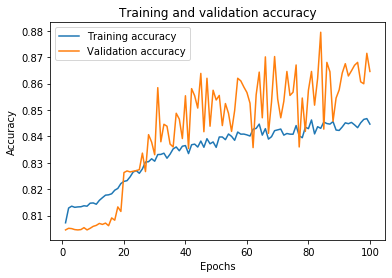

In [134]:
accuracy_plot(dropout_model.history)

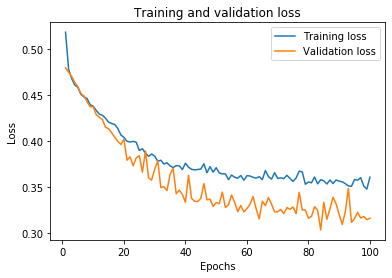

In [135]:
loss_plot(dropout_model.history)

#### Predictions

In [136]:
train_dropout_model_pred = dropout_model.predict_classes(X_train_std)
test_dropout_model_pred = dropout_model.predict_classes(X_test_std)

#### Getting evaluation metrics and evaluating model performance

In [137]:
compute_metrics(train_dropout_model_pred, y_train, test_dropout_model_pred, y_test)

Train metrics
Confusion matrix
[[32122   930]
 [ 4417  3261]]
----------------------------------------------
Accuracy:  0.8687208445863001
Precission:  0.8791154656668217
Recall:  0.9718625196659809
F1 Score:  0.9231653518414737


Test metrics
Confusion matrix
[[13768   397]
 [ 1898  1393]]
----------------------------------------------
Accuracy:  0.8685265811182401
Precission:  0.878845908336525
Recall:  0.9719731733145076
F1 Score:  0.9230666085615635


#### Model with Batch Normalization

In [138]:
np.random.seed(123)
tf.set_random_seed(123)

In [139]:
bn_model = Sequential()
bn_model.add(Dense(25, input_dim=21, activation='relu', kernel_initializer="glorot_normal"))
bn_model.add(BatchNormalization())
bn_model.add(Dense(15, activation='relu', kernel_initializer="glorot_normal"))
bn_model.add(BatchNormalization())
bn_model.add(Dense(1, activation='sigmoid',kernel_initializer="glorot_normal"))

In [140]:
bn_model.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_78 (Dense)             (None, 25)                550       
_________________________________________________________________
batch_normalization_1 (Batch (None, 25)                100       
_________________________________________________________________
dense_79 (Dense)             (None, 15)                390       
_________________________________________________________________
batch_normalization_2 (Batch (None, 15)                60        
_________________________________________________________________
dense_80 (Dense)             (None, 1)                 16        
Total params: 1,116
Trainable params: 1,036
Non-trainable params: 80
_________________________________________________________________


In [141]:
bn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [142]:
bn_model_history = bn_model.fit(X_train_std, y_train, epochs=100,
                                batch_size=best_params['best_batch_size'], 
                                validation_split=0.2)

Train on 32584 samples, validate on 8146 samples
Epoch 1/100
32584/32584 [==============================] - 5s 140us/step - loss: 0.4830 - accuracy: 0.7951 - val_loss: 0.4794 - val_accuracy: 0.8103
Epoch 2/100
32584/32584 [==============================] - 4s 108us/step - loss: 0.4231 - accuracy: 0.8228 - val_loss: 0.4822 - val_accuracy: 0.8086
Epoch 3/100
32584/32584 [==============================] - 3s 107us/step - loss: 0.4020 - accuracy: 0.8295 - val_loss: 0.4514 - val_accuracy: 0.8154
Epoch 4/100
32584/32584 [==============================] - 4s 108us/step - loss: 0.3847 - accuracy: 0.8363 - val_loss: 0.4540 - val_accuracy: 0.8141
Epoch 5/100
32584/32584 [==============================] - 4s 117us/step - loss: 0.3674 - accuracy: 0.8427 - val_loss: 0.4427 - val_accuracy: 0.8157
Epoch 6/100
32584/32584 [==============================] - 4s 112us/step - loss: 0.3543 - accuracy: 0.8497 - val_loss: 0.4378 - val_accuracy: 0.8233
Epoch 7/100
32584/32584 [==============================] 

32584/32584 [==============================] - 3s 105us/step - loss: 0.2806 - accuracy: 0.8797 - val_loss: 0.4208 - val_accuracy: 0.8183
Epoch 56/100
32584/32584 [==============================] - 3s 106us/step - loss: 0.2806 - accuracy: 0.8808 - val_loss: 0.4325 - val_accuracy: 0.8269
Epoch 57/100
32584/32584 [==============================] - 3s 103us/step - loss: 0.2798 - accuracy: 0.8783 - val_loss: 0.3455 - val_accuracy: 0.8416
Epoch 58/100
32584/32584 [==============================] - 3s 103us/step - loss: 0.2831 - accuracy: 0.8790 - val_loss: 0.3597 - val_accuracy: 0.8354
Epoch 59/100
32584/32584 [==============================] - 3s 103us/step - loss: 0.2864 - accuracy: 0.8791 - val_loss: 0.3988 - val_accuracy: 0.8246
Epoch 60/100
32584/32584 [==============================] - 3s 104us/step - loss: 0.2788 - accuracy: 0.8806 - val_loss: 0.3352 - val_accuracy: 0.8566
Epoch 61/100
32584/32584 [==============================] - 3s 104us/step - loss: 0.2803 - accuracy: 0.8796 - val

#### Predictions

In [143]:
train_bn_model_pred = bn_model.predict_classes(X_train_std)
test_bn_model_pred = bn_model.predict_classes(X_test_std)

#### Getting evaluation metrics and evaluating model performance

In [144]:
compute_metrics(train_bn_model_pred, y_train, test_bn_model_pred, y_test)

Train metrics
Confusion matrix
[[32645   407]
 [ 6214  1464]]
----------------------------------------------
Accuracy:  0.8374416891726001
Precission:  0.8400885251807818
Recall:  0.9876860704344669
F1 Score:  0.9079278552655365


Test metrics
Confusion matrix
[[13959   206]
 [ 2677   614]]
----------------------------------------------
Accuracy:  0.8348418881759854
Precission:  0.8390839144025006
Recall:  0.9854571126014825
F1 Score:  0.9063991428849714


#### model with weight decay

#### Find the best Weight Decay value

In [145]:
weight_decay_list = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]

In [146]:
def l2_model_func(l2_value):
    # create model
    l2_model = Sequential()
    
    l2_model.add(Dense(25, input_dim=21, activation='relu', kernel_regularizer=l2(l2_value),kernel_initializer="glorot_normal"))
    l2_model.add(Dropout(0.5))
    l2_model.add(Dense(15, activation='relu',kernel_regularizer=l2(l2_value), kernel_initializer="glorot_normal"))
    l2_model.add(Dropout(0.5))
    l2_model.add(Dense(1, activation='sigmoid',kernel_regularizer=l2(l2_value),kernel_initializer="glorot_normal"))
    
    # Compile model
    l2_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return l2_model   

In [147]:
hist_loss=[]

for weight_decay in weight_decay_list:
    
    np.random.seed(123)
    tf.set_random_seed(123)
    
    l2_model = l2_model_func(weight_decay)
    
    #Fit the model
    l2_model_history = l2_model.fit(X_train_std, y_train, epochs=1,
                                    validation_split=0.2,steps_per_epoch=50,
                                    validation_steps=50)
    
    hist_loss.append(l2_model_history.history['loss'])

Train on 32584 samples, validate on 8146 samples
Epoch 1/1
50/50 [==============================] - 2s 41ms/step - loss: 4.2370 - accuracy: 0.7381 - val_loss: 0.0710 - val_accuracy: 40.0994
Train on 32584 samples, validate on 8146 samples
Epoch 1/1
50/50 [==============================] - 2s 42ms/step - loss: 0.9977 - accuracy: 0.7556 - val_loss: 0.0174 - val_accuracy: 40.2345
Train on 32584 samples, validate on 8146 samples
Epoch 1/1
50/50 [==============================] - 2s 42ms/step - loss: 0.6607 - accuracy: 0.7585 - val_loss: 0.0115 - val_accuracy: 40.2222
Train on 32584 samples, validate on 8146 samples
Epoch 1/1
50/50 [==============================] - 2s 43ms/step - loss: 0.6224 - accuracy: 0.7606 - val_loss: 0.0108 - val_accuracy: 40.2161
Train on 32584 samples, validate on 8146 samples
Epoch 1/1
50/50 [==============================] - 2s 43ms/step - loss: 0.6200 - accuracy: 0.7587 - val_loss: 0.0107 - val_accuracy: 40.2222
Train on 32584 samples, validate on 8146 samples
E

In [151]:
# Get the weight decay and loss Dataframe
loss_weight_decay = pd.DataFrame([weight_decay_list, hist_loss]).T  

#Give the coloumn names
loss_weight_decay.columns=['weight_decay', 'loss']

#Sort the values and reset the index
loss_weight_decay=loss_weight_decay.sort_values('loss').reset_index().drop('index',axis=1)
loss_weight_decay

,weight_decay,loss
0,1e-06,[0.6181777894496918]
1,1e-05,[0.6194446575641632]
2,0.0001,[0.6223677611351013]
3,0.001,[0.6603421354293824]
4,0.01,[0.9976737642288208]
5,0.1,[4.244275660514831]


In [152]:
#pick the top weight decay
best_params['best_l2_value'] = loss_weight_decay.loc[:,'weight_decay'][0]

In [153]:
best_params['best_l2_value']

1e-06

#### Build model with the best l2 value

In [154]:
np.random.seed(123)
tf.set_random_seed(123)

In [155]:
bst_l2_model = Sequential()

bst_l2_model.add(Dense(25, input_dim=21, activation='relu', kernel_regularizer=l2(best_params['best_l2_value']),kernel_initializer="glorot_normal"))
bst_l2_model.add(Dropout(0.5))
bst_l2_model.add(Dense(15, activation='relu',kernel_regularizer=l2(best_params['best_l2_value']), kernel_initializer="glorot_normal"))
bst_l2_model.add(Dropout(0.5))
bst_l2_model.add(Dense(1, activation='sigmoid',kernel_regularizer=l2(best_params['best_l2_value']), kernel_initializer="glorot_normal"))

# Compile model
bst_l2_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [156]:
bst_l2_model.summary()

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_99 (Dense)             (None, 25)                550       
_________________________________________________________________
dropout_15 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_100 (Dense)            (None, 15)                390       
_________________________________________________________________
dropout_16 (Dropout)         (None, 15)                0         
_________________________________________________________________
dense_101 (Dense)            (None, 1)                 16        
Total params: 956
Trainable params: 956
Non-trainable params: 0
_________________________________________________________________


In [157]:
bst_l2_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [158]:
bst_l2_model_history = bst_l2_model.fit(X_train_std, y_train, epochs=100,
                                        batch_size=best_params['best_batch_size'], 
                                        validation_split=0.2, shuffle=True)

Train on 32584 samples, validate on 8146 samples
Epoch 1/100
32584/32584 [==============================] - 5s 153us/step - loss: 0.5186 - accuracy: 0.8073 - val_loss: 0.4798 - val_accuracy: 0.8046
Epoch 2/100
32584/32584 [==============================] - 3s 104us/step - loss: 0.4782 - accuracy: 0.8129 - val_loss: 0.4752 - val_accuracy: 0.8052
Epoch 3/100
32584/32584 [==============================] - 4s 111us/step - loss: 0.4682 - accuracy: 0.8136 - val_loss: 0.4704 - val_accuracy: 0.8051
Epoch 4/100
32584/32584 [==============================] - 4s 110us/step - loss: 0.4613 - accuracy: 0.8132 - val_loss: 0.4639 - val_accuracy: 0.8047
Epoch 5/100
32584/32584 [==============================] - 3s 103us/step - loss: 0.4583 - accuracy: 0.8134 - val_loss: 0.4590 - val_accuracy: 0.8046
Epoch 6/100
32584/32584 [==============================] - 4s 111us/step - loss: 0.4509 - accuracy: 0.8135 - val_loss: 0.4517 - val_accuracy: 0.8046
Epoch 7/100
32584/32584 [==============================] 

#### Predictions

In [159]:
train_bst_l2_model_pred = bst_l2_model.predict_classes(X_train_std)
test_bst_l2_model_pred = bst_l2_model.predict_classes(X_test_std)

#### Getting evaluation metrics and evaluating model performance

In [160]:
compute_metrics(train_bst_l2_model_pred, y_train, test_bst_l2_model_pred, y_test)

Train metrics
Confusion matrix
[[32193   859]
 [ 4710  2968]]
----------------------------------------------
Accuracy:  0.8632703167198625
Precission:  0.872368100154459
Recall:  0.9740106498850296
F1 Score:  0.9203916803659495


Test metrics
Confusion matrix
[[13788   377]
 [ 2061  1230]]
----------------------------------------------
Accuracy:  0.8603345554537122
Precission:  0.8699602498580352
Recall:  0.9733851041298976
F1 Score:  0.9187712400879589


**Best Parameters**

In [161]:
best_params

{'best_learning_rate': 0.2703,
 'best_batch_size': 32,
 'best_h_activation': 'relu',
 'best_kernel_init': 'glorot_normal',
 'best_optimizer': 'adam',
 'best_l2_value': 1e-06}

### Reference Links:

https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/

https://keras.io/